# Chebyshev center of a polyhedron

Consider the problem of finding the largest Euclidean ball that lies inside a polyhedron
		$$P = \{x \in \mathbb{R}^n \mid a_i^T x \le b_i, i=1,\ldots,m\}. $$
        
In the lecture, we showed that it can be modelled by the following LP:

$$\begin{array}{ll@{\quad}l}
\text{maximize}  & r &\\
\text{subject to}& a_i^Tx_c+r\|a_i\|_2 \le b_i & \text{for $i=1,\ldots,m$}
\end{array}$$

Code this model in Gurobi. Then test it in 2D so that it finds the center of a polygon given by a list of vertices.

For two points $(x_1,y_1)$ and $(x_2,y_2)$ we can calculate that $a = [-(y_2 - y_1), x_2 - x_1]$. Then we calculate $b$ as $b = a^T \cdot[x_1,y_1]$. At the end we are finding in wchich side should be inequality.

In [1]:
from gurobipy import Model, GRB
import gurobipy as gp
import numpy as np


vertices = [(0, 0), (2, 0), (2/3, 2 + 2/3), (-4/3, 2/3)]
n = len(vertices)
A = np.zeros((n, 2))
B = np.zeros(n)

for i in range(n):
    x_diff = vertices[(i + 1) % n][0] - vertices[i][0]
    y_diff = vertices[(i + 1) % n][1] - vertices[i][1]
    
    a_i = np.array([-y_diff, x_diff])
    b_i = np.dot(a_i, vertices[i])

    # Decide which side of inequality
    if np.dot(a_i, vertices[(i + 2) % n]) >= b_i:
        a_i, b_i = -a_i, -b_i

    A[i] = a_i
    B[i] = b_i


In [2]:
def chebyshev(dim, A, B):
    try:
        # Create a new model
        m = gp.Model("Chebyshev")

        # Create variables
        x_center = m.addMVar(shape=dim, name="x_center", lb=-GRB.INFINITY)
        r = m.addVar(name="r", lb=0.0)

        # Set objective
        m.setObjective(r, GRB.MAXIMIZE)

        # Build rhs vector
        rhs = B

        # Add constraints for each row of A
        for i in range(A.shape[0]):
            m.addConstr(A[i, :] @ x_center + r * np.linalg.norm(A[i, :]) <= rhs[i], name="c{}".format(i))

        # Optimize model
        m.optimize()

        optimal_x = x_center.X
        optimal_r = r.X
        objective_value = m.ObjVal

        return optimal_x, optimal_r, objective_value

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ": " + str(e))
        return None, None, None

    except AttributeError:
        print('Encountered an attribute error')
        return None, None, None

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (linux64 - "Ubuntu 22.04.4 LTS")

CPU model: Intel(R) Core(TM) i5-8265U CPU @ 1.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 4 rows, 3 columns and 11 nonzeros
Model fingerprint: 0x19595d2d
Coefficient statistics:
  Matrix range     [7e-01, 3e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [0e+00, 0e+00]
  RHS range        [4e+00, 5e+00]
Presolve removed 4 rows and 3 columns
Presolve time: 0.00s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    9.9200259e-01   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  9.920025865e-01


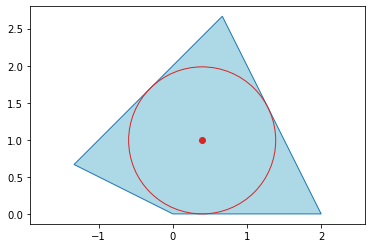

Circle at the point (x,y) = [0.3949061  0.99200259], and radius equal 0.9920025864696703


In [68]:
import matplotlib.pyplot as plt
xs, ys = zip(*(vertices + [vertices[0]])) #create lists of x and y values

plt.figure()
plt.axis('equal')
plt.fill(xs,ys,facecolor='lightblue', edgecolor='tab:blue', linewidth=1) 


optimal_x, optimal_r, objective_value = chebyshev(2, A, B)
cir=plt.Circle((optimal_x[0], optimal_x[1]), optimal_r, fill=False, edgecolor='tab:red')
plt.gca().add_patch(cir)
plt.plot(optimal_x[0], optimal_x[1], 'o', color='tab:red')
plt.show()
print(f"Circle at the point (x,y) = {optimal_x}, and radius equal {optimal_r}")